In [1]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
from os import path
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/Users/ryaneagan/opt/anaconda3/envs/metanalysis/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [17]:
def plot_field(field, title, time_idx, level_value, cmap='viridis', prj='PlateCarree'):
    """Plot a horizontal map of a 3D field at given time and level."""
    # Select the data slice
    field_sel = field.sel(time=field.time[time_idx], plev=level_value, method="nearest")

    if prj == 'PlateCarree':
        proj = ccrs.PlateCarree()
    elif prj == 'SouthPolarStereo':
        proj = ccrs.SouthPolarStereo()

    # Create the plot
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=proj)
    field_plot = field_sel.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        cbar_kwargs={"label": f"{field.name}"},
    )
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(f"{title} at {int(level_value/100)} hPa, time: {str(field.time[time_idx].values)[:10]}")
    plt.show()

# Example usage:
#plot_field(sigma, "Static Stability (σ)", time_idx=0, level_value=50000, cmap="plasma")
#plot_field(QGPV_vertical, "Vertical QGPV", time_idx=0, level_value=50000, cmap="RdBu_r")

In [3]:
gfdlesm2g_files = '/Volumes/DataDrive/Met2GradData/rcp45-GFDL-ESM2G/'

gfdl_temp = path.join(gfdlesm2g_files,'ta_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')
gfdl_uwind = path.join(gfdlesm2g_files,'ua_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')
gfdl_vwind = path.join(gfdlesm2g_files,'va_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')
gfdl_gp = path.join(gfdlesm2g_files,'zg_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')

In [4]:
temp = xr.open_dataset(gfdl_temp)
uwind = xr.open_dataset(gfdl_uwind)
vwind = xr.open_dataset(gfdl_vwind)
gp = xr.open_dataset(gfdl_gp)

/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_2164/2655856887.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  temp = xr.open_dataset(gfdl_temp)
/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_2164/2655856887.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  uwind = xr.open_dataset(gfdl_uwind)
/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_2164/2655856887.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vwind = xr.open_dataset(gfdl_vwind)
/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ip

In [5]:
ds = xr.merge([gp, temp, uwind, vwind])

In [9]:
# Define the polar stereographic projection for the South Pole
#south_pole_proj = Proj(proj='stere', lat_ts=-71, lat_0=-90, lon_0=0, ellps='WGS84')

# Convert lat/lon to 2D arrays
lats = ds['lat'].values
lons = ds['lon'].values

# If 1D, make 2D meshgrid
lon2d, lat2d = np.meshgrid(lons, lats)

# Transform to x, y (in meters)
#x, y = south_pole_proj(lon2d, lat2d)

# Add x and y as new coordinates
#ds = ds.assign_coords({'x': (('lat', 'lon'), x),
#                       'y': (('lat', 'lon'), y)})

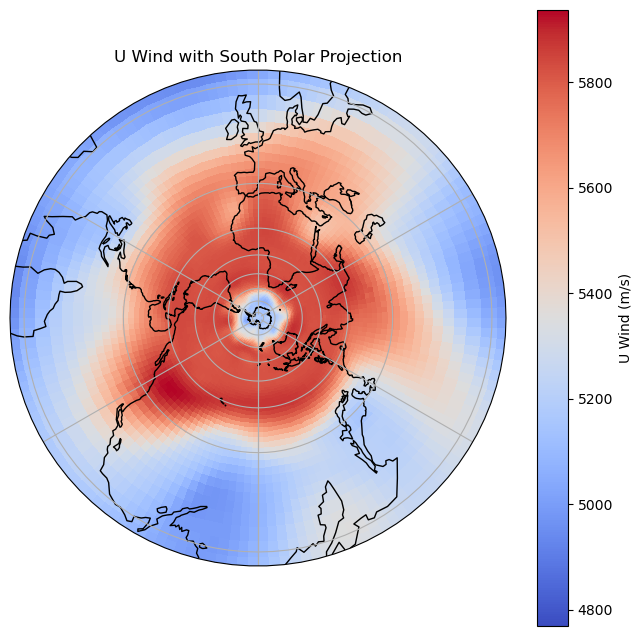

In [ ]:
""" # Choose a variable and time slice to plot
# South Polar Stereographic CRS
proj = ccrs.SouthPolarStereo()

data = ds['zg'][0, 3, :, :]  # Example: temperature at surface or level 0

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})

# Use `transform` to indicate original CRS (PlateCarree)
pc = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap='coolwarm')


ax.coastlines()
ax.gridlines()
plt.colorbar(pc, ax=ax, orientation='vertical', label='U Wind (m/s)')
plt.title("U Wind with South Polar Projection")
plt.show() """

In [6]:
# Select variables
Z = ds['zg']  # Geopotential height [m]
U = ds['ua']  # Zonal wind [m/s]
V = ds['va']  # Meridional wind [m/s]
T = ds['ta']  # Temperature [K]
lat = ds['lat']
lon = ds['lon']
lev = ds['plev']  # Pressure levels (Pa)
time = ds['time']

In [7]:
# Define constants
omega = 7.2921e-5  # Earth's rotation rate [s^-1]
R = 287.0  # Gas constant for dry air [J/(kg*K)]
g = 9.81  # Gravity [m/s^2]
f0 = 2 * omega * np.sin(np.deg2rad(lat))  # Coriolis parameter

# Compute streamfunction ψ
psi = (Z / g) * (lev / f0)

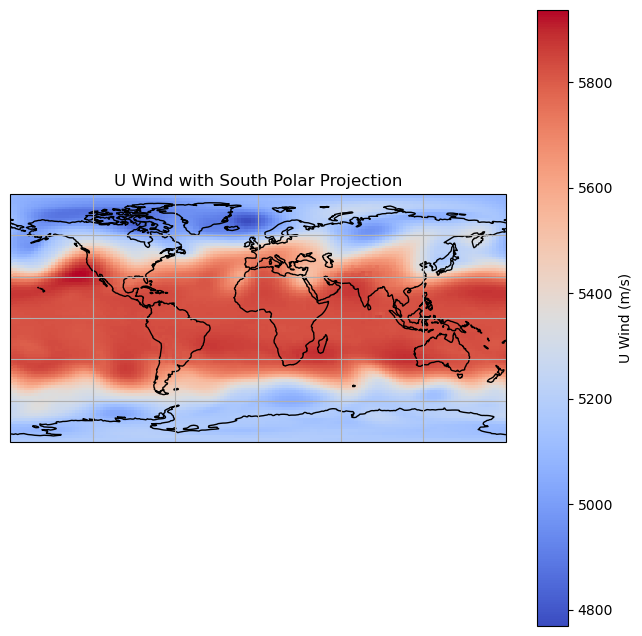

In [10]:
# Choose a variable and time slice to plot
# South Polar Stereographic CRS
#proj = ccrs.SouthPolarStereo()
proj = ccrs.PlateCarree()

data = Z[0, 3, :, :]  # Example: temperature at surface or level 0

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})

# Use `transform` to indicate original CRS (PlateCarree)
pc = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap='coolwarm')


ax.coastlines()
ax.gridlines()
plt.colorbar(pc, ax=ax, orientation='vertical', label='U Wind (m/s)')
plt.title("U Wind with South Polar Projection")
plt.show()

In [11]:
# Assuming lat and lon are 1D arrays, and psi is a 2D DataArray with dims ('lat', 'lon')
lon2d, lat2d = np.meshgrid(lon, lat)

# Convert degrees to radians and compute dx, dy as 2D arrays
R = 6371000  # Earth radius [m]
dx = np.gradient(lon) * (np.pi / 180) * R * np.cos(np.deg2rad(lat2d))  # shape: (lat, lon)
dy = np.gradient(lat) * (np.pi / 180) * R  # shape: (lat,)

# Broadcast dy to 2D to match shape
dy2d = np.broadcast_to(dy[:, np.newaxis], dx.shape)

# Compute second derivatives using xarray DataArray operations (assuming psi is a DataArray)
d2psi_dx2 = (psi.shift(lon=-1) - 2 * psi + psi.shift(lon=1)) / (dx ** 2)
d2psi_dy2 = (psi.shift(lat=-1) - 2 * psi + psi.shift(lat=1)) / (dy2d ** 2)

laplacian_psi = d2psi_dx2 + d2psi_dy2

In [ ]:
# Ensure lev is a coordinate
T = T.assign_coords(lev=lev)
psi = psi.assign_coords(lev=lev)

# Compute potential temperature
theta = T * (100000 / T.lev) ** (R / 1004)

# Compute d(log(theta))/dp along 'lev' (pressure) dimension
log_theta = np.log(theta)
dtheta_dp = log_theta.differentiate('lev')

# Static stability parameter sigma
sigma = -(R * T / T.lev) * dtheta_dp

# Vertical derivatives of psi
dpsi_dp = psi.differentiate('lev')
d2psi_dp2 = dpsi_dp.differentiate('lev')

# QGPV vertical term
QGPV_vertical = ((f0**2 / sigma) * dpsi_dp).differentiate('lev')

/Users/ryaneagan/opt/anaconda3/envs/metanalysis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ryaneagan/opt/anaconda3/envs/metanalysis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ryaneagan/opt/anaconda3/envs/metanalysis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1314: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


In [13]:
QGPV_vertical.max()

<xarray.DataArray ()> Size: 8B
array(nan)

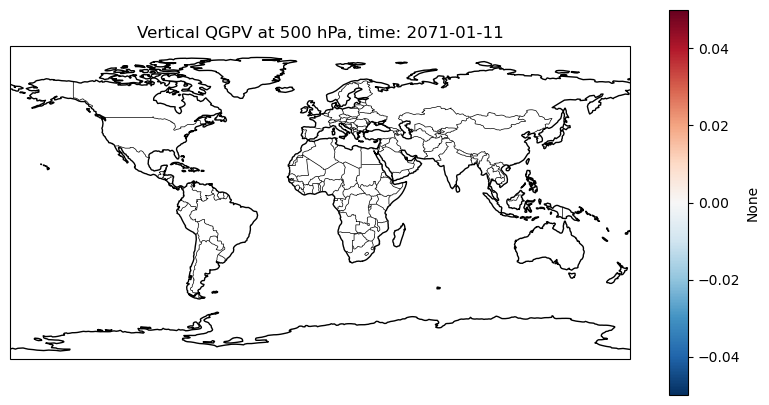

In [19]:
plot_field(QGPV_vertical, "Vertical QGPV", time_idx=10, level_value=50000, cmap="RdBu_r")

In [22]:
# Compute full QGPV
QGPV = laplacian_psi + f0 + QGPV_vertical

In [14]:
# Z should be an xarray.DataArray with coordinates 'lat' and 'lon'
# Assign lat/lon as coordinates if not already
Z = Z.assign_coords(lat=lat, lon=lon)

# Compute geostrophic winds using derivatives
ug = - (1 / f0) * Z.differentiate('lat') * (np.pi / 180) * 6371000  # dΦ/dy
vg = (1 / f0) * Z.differentiate('lon') * (np.pi / 180) * 6371000 * np.cos(np.deg2rad(Z.lat))

In [15]:
# Compute Geostrophic Vorticity
dvg_dx = vg.differentiate('lon') * (np.pi / 180) * 6371000 * np.cos(np.deg2rad(Z.lat))
dug_dy = ug.differentiate('lat') * (np.pi / 180) * 6371000
zeta_g = dvg_dx - dug_dy

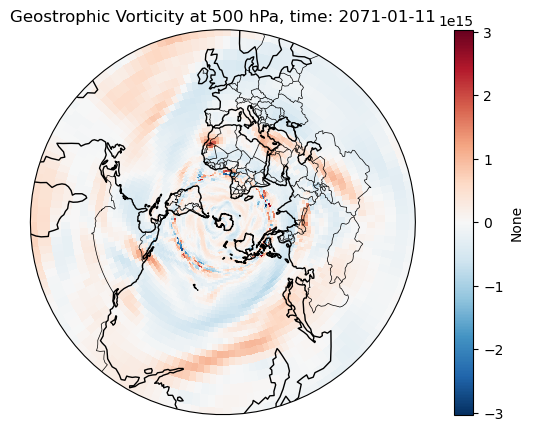

In [20]:
plot_field(zeta_g, "Geostrophic Vorticity", time_idx=10, level_value=50000, cmap="RdBu_r", prj='SouthPolarStereo')

In [28]:
# Compute the Rossby Wave Source

dU_dx = U.differentiate('lon') * (np.pi / 180) * 6371000 * np.cos(np.deg2rad(Z.lat))
dV_dy = V.differentiate('lat') * (np.pi / 180) * 6371000
dvg_dy = vg.differentiate('lat') * (np.pi / 180) * 6371000

rws = - (zeta_g * dU_dx + dV_dy) - f0 * dvg_dy

In [30]:
# Compute Rossby Wave Tendency

# Ensure QGPV has time coordinate as datetime64
QGPV['time'] = time  # if not already assigned

# Compute temporal derivative
QGPV_tendency = QGPV.differentiate('time')  # units: 1/s if time is in datetime64

In [31]:
QGPV_tendency

<xarray.DataArray (time: 1825, plev: 8, lat: 90, lon: 144)> Size: 2GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], shape=(1825, 8, 90, 144))
Coordinates:
  * plev     (plev) float64 64B 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * lat      (lat) float64 720B -89.49 -87.98 -85.96 ... 85.96 87.98 89.49
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.3 353.8 356.2 358.8
    x        (lat, lon) float64 104kB 1.198e+03 3.593e+03 ... -6.074e+07
    y        (lat, lon) float64 104kB 5.492e+04 5.482e+04 ... 2.783e+09
    lev      (plev) float64 64B 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * time     (time) object 15kB 2071-01-01 12:00:00 ... 2075-12-31 12:00:00

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_variable(variable, title, cmap="coolwarm"):
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.contourf(lon, lat, variable[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(label=title)
    plt.title(title)
    plt.show()

# Plot QGPV, RWS, and Tendency
plot_variable(QGPV[0], "Quasi-Geostrophic Potential Vorticity")
plot_variable(rws[0], "Rossby Wave Source")
plot_variable(QGPV_tendency[0], "QGPV Tendency")

Function below to do all this magic

In [ ]:
import numpy as np
import xarray as xr

def compute_rws(Z, U, V, f0=1e-4):
    """
    Compute Rossby Wave Source (RWS) from geopotential (Z), and wind components (U, V).
    
    Parameters:
    -----------
    Z : xarray.DataArray
        Geopotential height (m^2/s^2), with dimensions ('time', 'lev', 'lat', 'lon')
    U, V : xarray.DataArray
        Zonal and meridional wind components (m/s), with same dimensions as Z
    f0 : float
        Reference Coriolis parameter (s^-1). Default is mid-latitude value ~1e-4.

    Returns:
    --------
    rws : xarray.DataArray
        Rossby Wave Source (1/s^2), same shape as input fields.
    """

    # Earth radius [m]
    R = 6371000
    deg2rad = np.pi / 180
    
    # Get lat in radians for dx correction
    lat_rad = np.deg2rad(Z['lat'])

    # Compute geostrophic wind components
    dZ_dlat = Z.differentiate('lat') * deg2rad * R
    dZ_dlon = Z.differentiate('lon') * deg2rad * R * np.cos(lat_rad)

    ug = - (1 / f0) * dZ_dlat
    vg = (1 / f0) * dZ_dlon

    # Compute geostrophic vorticity
    dug_dlat = ug.differentiate('lat') * deg2rad * R
    dvg_dlon = vg.differentiate('lon') * deg2rad * R * np.cos(lat_rad)
    zeta_g = dvg_dlon - dug_dlat

    # Derivatives of basic flow
    dU_dlon = U.differentiate('lon') * deg2rad * R * np.cos(lat_rad)
    dV_dlat = V.differentiate('lat') * deg2rad * R
    dvg_dlat = vg.differentiate('lat') * deg2rad * R

    # Rossby wave source
    rws = - (zeta_g * dU_dlon + dV_dlat) - f0 * dvg_dlat
    rws.name = 'RWS'

    return rws

In [ ]:
# Usage example of above function:

# Make sure Z, U, V have dimensions and coordinates: ('time', 'lev', 'lat', 'lon')
rws = compute_rws(Z, U, V)

# Then plot as usual (e.g., at 200 hPa and time 0)
plot_field(rws, "Rossby Wave Source", time_idx=0, level_value=20000, cmap="RdBu_r")